In [1]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader

from sklearn.metrics import roc_auc_score
import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df_features = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

In [3]:
# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)
classified = df_merge.loc[df_merge['class'].loc[df_merge['class']!=2].index].drop('txId', axis=1)
unclassified = df_merge.loc[df_merge['class'].loc[df_merge['class']==2].index].drop('txId', axis=1)

# storing classified unclassified nodes seperatly for training and testing purpose
classified_edges = df_edges.loc[df_edges['txId1'].isin(classified[0]) & df_edges['txId2'].isin(classified[0])]
unclassifed_edges = df_edges.loc[df_edges['txId1'].isin(unclassified[0]) | df_edges['txId2'].isin(unclassified[0])]
del df_features, df_classes

In [4]:
# all nodes in data
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T

# for undirected graph
# edge_index_ = np.array([edge_index[1,:], edge_index[0, :]])
# edge_index = np.concatenate((edge_index, edge_index_), axis=1)

edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double)
print(edge_index.shape)

torch.Size([2, 234355])


In [5]:
# maping txIds to corresponding indexes, to pass node features to the model
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)
classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index
# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0) 

In [6]:
labels = node_features['class'].values
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.double), dtype=torch.double)

# converting data to PyGeometric graph data format
data_train = Data(x=node_features, edge_index=edge_index, edge_attr=weights,
                               y=torch.tensor(labels, dtype=torch.double)) #, adj= torch.from_numpy(np.array(adj))

In [7]:
y_train = labels[classified_idx]

# spliting train set and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid, train_idx, valid_idx = train_test_split(node_features[classified_idx], y_train, classified_idx, test_size=0.15, random_state=42, stratify=y_train)

In [8]:
data_train.y[classified_idx].sum()

tensor(4545., dtype=torch.float64)

In [9]:
# data_train.y = data_train.y.double()
# data_train.x = data_train.x.double()

In [10]:
import gc
gc.collect()

21

In [84]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = GCNConv(165, 64)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(64, 64)
        self.conv4 = GCNConv(64, 1) 

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.conv4(x, edge_index)

        return F.sigmoid(x)

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
model.double()
data_train = data_train.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

loss_vals = []
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data_train)
    # data_train.y.unsqueeze(1)
    out = out.reshape((data_train.x.shape[0]))
    loss = criterion(out[train_idx], data_train.y[train_idx])
    auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], out.detach().cpu().numpy()[train_idx]) #[train_idx]
    loss.backward()
    loss_vals.append(loss.item())
    optimizer.step()
    if epoch%5 == 0:
      print("epoch: {} - loss: {} - roc: {}".format(epoch, loss.item(), auc))

epoch: 0 - loss: 0.5491862942862226 - roc: 0.5924025157535384
epoch: 5 - loss: 0.2822219000551333 - roc: 0.8615851683747707
epoch: 10 - loss: 0.24404413042991407 - roc: 0.8883157455193382
epoch: 15 - loss: 0.22872970550261196 - roc: 0.8991110285365376
epoch: 20 - loss: 0.21082939387138339 - roc: 0.9110149945523298
epoch: 25 - loss: 0.198612720645579 - roc: 0.917839918832744
epoch: 30 - loss: 0.18796206215580835 - roc: 0.9229611143821711
epoch: 35 - loss: 0.180031570159513 - roc: 0.9280800123457912
epoch: 40 - loss: 0.17340966389202492 - roc: 0.9329914535316388
epoch: 45 - loss: 0.16708965229731082 - roc: 0.9372265564853716
epoch: 50 - loss: 0.1608378556811464 - roc: 0.9409774124266835
epoch: 55 - loss: 0.15598754571962023 - roc: 0.9445171803899415
epoch: 60 - loss: 0.15087099676073243 - roc: 0.9484114651184292
epoch: 65 - loss: 0.1443213852705805 - roc: 0.9518349766894337
epoch: 70 - loss: 0.14196280668157207 - roc: 0.9531947633482271
epoch: 75 - loss: 0.13707783569499424 - roc: 0.9570

In [138]:
preds = model(data_train)
preds = preds.detach().cpu().numpy()

In [139]:
from sklearn.metrics import accuracy_score
out_labels = preds > 0.6
train_acc = accuracy_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
train_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], preds[train_idx])
print("train accuracy: ", train_acc)
print("train AUC: ", train_auc)

train accuracy:  0.9646529725359407
train AUC:  0.984059291687781


In [140]:
valid_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[valid_idx], preds[valid_idx])
out_labels = out.detach().cpu().numpy() > 0.6
valid_acc = accuracy_score(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])
print("valid accuracy: ", valid_acc)
print("valid AUC: ", valid_auc)

valid accuracy:  0.9597709377236936
valid AUC:  0.9592036655263076


In [141]:
# total predicted illicit (positives) in test set
out_labels[unclassified_idx].sum()

15067

In [142]:
# total predicted positives in validation set
out_labels[valid_idx].sum()

559

In [143]:
from sklearn.metrics import roc_curve, confusion_matrix
# confusion matrix for validation data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])
cm

array([[6224,   79],
       [ 202,  480]])

In [144]:
# confusion matrix for train data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
cm

array([[35459,   257],
       [ 1004,  2859]])

In [145]:
from sklearn.metrics import f1_score, classification_report

In [146]:
f1_score(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])

0.7735697018533441

In [149]:
print(classification_report(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx]))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      6303
         1.0       0.86      0.70      0.77       682

    accuracy                           0.96      6985
   macro avg       0.91      0.85      0.88      6985
weighted avg       0.96      0.96      0.96      6985



In [147]:
f1_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])

0.8193150881215073

In [148]:
print(classification_report(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx]))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     35716
         1.0       0.92      0.74      0.82      3863

    accuracy                           0.97     39579
   macro avg       0.94      0.87      0.90     39579
weighted avg       0.97      0.97      0.97     39579



Text(0, 0.5, 'loss')

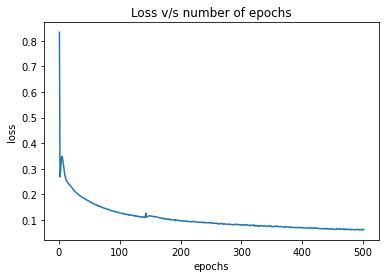

In [136]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(1, 501, 501).astype(int), loss_vals)
plt.title("Loss v/s number of epochs")
plt.xlabel("epochs")
plt.ylabel("loss")

In [39]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from collections import OrderedDict
import numpy as np
import torch.nn.functional as F

class FeatureLayer(torch.nn.Module):
    def __init__(self):
        super(FeatureLayer, self).__init__()
        
        self.conv1 = GCNConv(165, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 1) 

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x.float(), edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
#         x = self.conv2(x, edge_index)
# #         print(x.shape)
#         x = F.relu(x)
#         x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.conv3(x, edge_index)
#         print(x.shape)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)        
        
        x = self.conv4(x, edge_index)

        return F.sigmoid(x)
    

class Tree(nn.Module):
    def __init__(self,depth,n_in_feature,used_feature_rate,n_class):
        super(Tree, self).__init__()
        self.depth = depth
        self.n_leaf = 2 ** depth
        self.n_class = n_class

        # used features in this tree
        n_used_feature = int(n_in_feature*used_feature_rate)
        onehot = np.eye(n_in_feature)
        using_idx = np.random.choice(np.arange(n_in_feature), n_used_feature, replace=False)
        self.feature_mask = onehot[using_idx].T
        self.feature_mask = Parameter(torch.from_numpy(self.feature_mask).type(torch.FloatTensor),requires_grad=False)

        # leaf label distribution
        self.pi = np.random.rand(self.n_leaf,n_class)
        self.pi = Parameter(torch.from_numpy(self.pi).type(torch.FloatTensor),requires_grad=True)
        
        # decision
        self.decision = nn.Sequential(OrderedDict([
                        ('linear1',nn.Linear(n_used_feature,self.n_leaf)),
                        ('sigmoid', nn.Sigmoid()),
                        ]))

    def forward(self,x):
        """
        :param x(Variable): [batch_size,n_features]
        :return: route probability (Variable): [batch_size,n_leaf]
        """
        if x.is_cuda and not self.feature_mask.is_cuda:
            self.feature_mask = self.feature_mask.cuda()

        feats = torch.mm(x,self.feature_mask) # ->[batch_size,n_used_feature]
        decision = self.decision(feats) # ->[batch_size,n_leaf]

        decision = torch.unsqueeze(decision,dim=2)
        decision_comp = 1-decision
        decision = torch.cat((decision,decision_comp),dim=2) # -> [batch_size,n_leaf,2]

        # compute route probability
        # note: we do not use decision[:,0]
        batch_size = x.size()[0]
        _mu = Variable(x.data.new(batch_size,1,1).fill_(1.))
        begin_idx = 1
        end_idx = 2
        for n_layer in range(0, self.depth):
            _mu = _mu.view(batch_size,-1,1).repeat(1,1,2)
            _decision = decision[:, begin_idx:end_idx, :]  # -> [batch_size,2**n_layer,2]
            _mu = _mu*_decision # -> [batch_size,2**n_layer,2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (n_layer+1)

        mu = _mu.view(batch_size,self.n_leaf)
        return mu

    def get_pi(self):
        return F.softmax(self.pi,dim=-1)

    def cal_prob(self,mu,pi):
        """
        :param mu [batch_size,n_leaf]
        :param pi [n_leaf,n_class]
        :return: label probability [batch_size,n_class]
        """
        p = torch.mm(mu,pi)
        return p


    def update_pi(self,new_pi):
        self.pi.data=new_pi


class Forest(nn.Module):
    def __init__(self,n_tree,tree_depth,n_in_feature,tree_feature_rate,n_class):
        super(Forest, self).__init__()
        self.trees = nn.ModuleList()
        self.n_tree  = n_tree
        for _ in range(n_tree):
            tree = Tree(tree_depth,n_in_feature,tree_feature_rate,n_class)
            self.trees.append(tree)

    def forward(self,x):
        probs = []
        for tree in self.trees:
            mu = tree(x)
            p=tree.cal_prob(mu,tree.get_pi())
            probs.append(p.unsqueeze(2))
            
#         print(np.array(probs).shape)
        probs = torch.cat(probs,dim=2)
#         print(probs.shape)
        prob = torch.sum(probs,dim=2)/self.n_tree
#         print(prob.shape)
        return prob

class NeuralDecisionForest(nn.Module):
    def __init__(self, feature_layer, forest):
        super(NeuralDecisionForest, self).__init__()
        self.feature_layer = feature_layer
        self.forest = forest

    def forward(self, x):
        out = self.feature_layer(x)
#         print("1 out.shape: ",out.shape)
        out = out.view(x.size()[0],-1)
        out = out[train_idx]
        out = self.forest(out)
        return out

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
model.double()
data_train = data_train.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision # for data
# import ndf # for Neural Decision Forest Model

# hyper-parameters
batch_size = 128
feat_dropout = 0.0
n_tree = 1
tree_depth = 1
tree_feature_rate = 0.3
lr = 0.001
epochs = 2001
report_every = 10
shallow = False

# change gpuid to use GPU
cuda = 0 
gpuid = 1
n_class = 2

cuda = gpuid>=0
if gpuid>=0:
    torch.cuda.set_device(gpuid)
else:
    print("WARNING: RUN WITHOUT GPU")
data_train = data_train.to(device)

def prepare_model():
#     feat_layer = FeatureLayer()
    model = FeatureLayer()
#     forest = Forest(n_tree=n_tree,tree_depth=tree_depth,n_in_feature=feat_layer.get_out_feature_size(),
#                         tree_feature_rate=tree_feature_rate,n_class=n_class)
#     model = NeuralDecisionForest(feat_layer,forest)

    if cuda:
        model = model.to(device)
    else:
        model = model.cpu()

    return model

def prepare_optim(model):
    params = [ p for p in model.parameters() if p.requires_grad]
    return torch.optim.Adam(params, lr=lr, weight_decay=1e-5)

def train(model): 
#     model = Net()
#     model = model.cuda()
    
    model.train()
    for epoch in range(70):
        optimizer.zero_grad()
        out = model(data_train)
        # data_train.y.unsqueeze(1)
        out = out.reshape((data_train.x.shape[0]))
        loss = criterion(out[train_idx], data_train.y[train_idx].float())
        auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], out.detach().cpu().numpy()[train_idx]) #[train_idx]
        loss.backward()
        optimizer.step()
        if epoch%5 == 0:
          print("epoch: {} - loss: {} - roc: {}".format(epoch, loss.item(), auc))
        

def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")       


def main():

    # GPU
#     cuda = gpuid>=0
#     if gpuid>=0:
#         torch.cuda.set_device(gpuid)
#     else:
#         print("WARNING: RUN WITHOUT GPU")
#     db = prepare_db()
    model = prepare_model()
#     optim = prepare_optim(model)
    train(model)
    
    print(model)
    model_summary(model)
    
    
if __name__ == '__main__':
    main()

epoch: 0 - loss: 0.6487333178520203 - roc: 0.5441406169480308
epoch: 5 - loss: 0.6552221775054932 - roc: 0.5343683938066132
epoch: 10 - loss: 0.6598442792892456 - roc: 0.5320074286964901
epoch: 15 - loss: 0.6488624811172485 - roc: 0.5435367903790269
epoch: 20 - loss: 0.672092616558075 - roc: 0.531872860472876
epoch: 25 - loss: 0.6577941179275513 - roc: 0.5326044603547871
epoch: 30 - loss: 0.6558635234832764 - roc: 0.5319816080358042
epoch: 35 - loss: 0.6591197848320007 - roc: 0.53385372733794
epoch: 40 - loss: 0.6640057563781738 - roc: 0.5350191251912324
epoch: 45 - loss: 0.6633312106132507 - roc: 0.5305196114241706
epoch: 50 - loss: 0.6718183755874634 - roc: 0.5202636087601887
epoch: 55 - loss: 0.6529807448387146 - roc: 0.5420067721812776
epoch: 60 - loss: 0.6557099223136902 - roc: 0.5348289945297744
epoch: 65 - loss: 0.6486172676086426 - roc: 0.5362826125635123
FeatureLayer(
  (conv1): GCNConv(165, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 1)

In [87]:
data_train = data_train.to(device)
model.to(device)
model.train()
for epoch in range(70):
    optimizer.zero_grad()
    out = model(data_train)
    # data_train.y.unsqueeze(1)
    out = out.reshape((data_train.x.shape[0]))
    loss = criterion(out[train_idx], data_train.y[train_idx])
    auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], out.detach().cpu().numpy()[train_idx]) #[train_idx]
    loss.backward()
    optimizer.step()
    if epoch%5 == 0:
      print("epoch: {} - loss: {} - roc: {}".format(epoch, loss.item(), auc))



torch.Size([203769, 64])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1!

In [77]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision # for data
# import ndf # for Neural Decision Forest Model


# hyper-parameters
batch_size = 128
feat_dropout = 0.0
n_tree = 1
tree_depth = 1
tree_feature_rate = 0.3
lr = 0.001
epochs = 2001
report_every = 10
shallow = False

# change gpuid to use GPU
cuda = 0 
gpuid = 1
n_class = 2

cuda = gpuid>=0
if gpuid>=0:
    torch.cuda.set_device(gpuid)
else:
    print("WARNING: RUN WITHOUT GPU")
data_train = data_train.cuda()

# return normalized dataset divided into two sets
def prepare_db():
    train_dataset = torchvision.datasets.MNIST('./data/mnist', train=True, download=True,
                                               transform=torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                               ]))

    eval_dataset = torchvision.datasets.MNIST('./data/mnist', train=False, download=True,
                                               transform=torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                               ]))
    return {'train':train_dataset,'eval':eval_dataset}        

def prepare_model():
    feat_layer = FeatureLayer()
    forest = Forest(n_tree=n_tree,tree_depth=tree_depth,n_in_feature=feat_layer.get_out_feature_size(),
                        tree_feature_rate=tree_feature_rate,n_class=n_class)
    model = NeuralDecisionForest(feat_layer,forest)

    if cuda:
        model = model.cuda()
    else:
        model = model.cpu()

    return model

def prepare_optim(model):
    params = [ p for p in model.parameters() if p.requires_grad]
    return torch.optim.Adam(params, lr=lr, weight_decay=1e-5)

def train(model,optim,db): 
    model = FeatureLayer()
    model = model.cuda()
    
    for epoch in range(1, epochs + 1):
        if epoch % 100==0:
            preds = model(data_train)
            preds = preds.detach().cpu().numpy()
            out_labels = preds[:, 0] > 0.5
            
            train_acc = accuracy_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
            train_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
            cm = confusion_matrix(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
            print("train accuracy: ", train_acc)
            print("train AUC: ", train_auc)
            print("confusion matrix: ",cm)
            print("f1 score: ",f1_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx]))
        train_loss = float(0) # change

        # Update \Theta and \Pi

        model.train()
#         train_loader = torch.utils.data.DataLoader(db['train'],batch_size=batch_size, shuffle=True)
#         train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size, shuffle=True)
#         print(next(iter(train_loader)))

        out = model(data_train)
#         print("(data_train.x.shape[0]): ",(data_train.x.shape[0]))
#         print("out: ", out.shape)
#         out = out.reshape((data_train.x.shape[0]))
#         out = out[:, 0]
#         out = out.cuda()
#         print(torch.unique(out>1.0))
#         print(torch.unique(out<0.0))
#         print("data_train.y[train_idx].float(): ",data_train.y[train_idx].float())
#         target = F.one_hot(data_train.y[train_idx].type(torch.LongTensor), num_classes=2)
#         print("data_train.y.shape: ",target.shape)
#         loss = torch.nn.CrossEntropyLoss()
#         loss = loss(out[train_idx,:].cuda(), data_train.y[train_idx].type(torch.LongTensor).cuda())
        print(out[train_idx].reshape(-1).shape)
        print(data_train.y[train_idx].shape)
        loss = criterion(out[train_idx].reshape(-1), data_train.y[train_idx].float())
#         loss = F.nll_loss(torch.log(out[train_idx]).cuda(),data_train.y[train_idx].type(torch.LongTensor).cuda())
#         auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], out.detach().cpu().numpy()[train_idx]) #[train_idx]
        loss.backward()
        optimizer.step()
        if epoch%5 == 0:
          print("epoch: {} - loss: {} - roc:".format(epoch, loss.item()))
        
#         for batch_idx, loader in enumerate(train_loader):
#             print(batch_idx)
#             if cuda:
#                 data, target = data.cuda(), target.cuda()
#             data, target = Variable(data), Variable(target)
#             optim.zero_grad()
#         output = model(data)
#             loss = F.nll_loss(torch.log(output),target)
#             loss.backward()
#             #torch.nn.utils.clip_grad_norm([ p for p in model.parameters() if p.requires_grad],
#             #                              max_norm=5)
#             optim.step()
#             if batch_idx % report_every == 0:
#                 train_loss = loss.item() # change
#                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                     epoch, batch_idx * len(data), len(train_loader.dataset),
#                     100. * batch_idx / len(train_loader), loss.item()))

#         # Eval
#         model.eval()
#         test_loss = 0
#         correct = 0
#         test_loader = torch.utils.data.DataLoader(db['eval'], batch_size=batch_size, shuffle=True)
#         for data, target in test_loader:
#             if cuda:
#                 data, target = data.cuda(), target.cuda()

#             with torch.no_grad():
#                 data= Variable(data)
#             target = Variable(target)
#             output = model(data)
#             test_loss += F.nll_loss(torch.log(output), target, size_average=False).item() # sum up batch loss
#             pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#             correct += pred.eq(target.data.view_as(pred)).cpu().sum()

#         test_loss /= len(test_loader.dataset)
#         accuracy = float(correct) / len(test_loader.dataset)

#         print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f})\n'.format(
#             test_loss, correct, len(test_loader.dataset),
#             accuracy))

#         # for plotting (training)   
#         with open("plot_data_train_norm.csv", 'a+') as file:
#             file.write(str(epoch) + " " +  str(train_loss) + "\n")

#         # for plotting (testing)
#         with open("plot_data_eval_norm.csv", 'a+') as file:
#             file.write(str(epoch) + " " + str(test_loss) + " " + str(accuracy) + "\n")




def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")       


def main():

    # GPU
    cuda = gpuid>=0
    if gpuid>=0:
        torch.cuda.set_device(gpuid)
    else:
        print("WARNING: RUN WITHOUT GPU")
    db = prepare_db()
    model = prepare_model()
    optim = prepare_optim(model)
    train(model,optim,db)
    
    print(model)
    model_summary(model)
if __name__ == '__main__':
    main()

torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
epoch: 5 - loss: 0.7563723921775818 - roc:
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
epoch: 10 - loss: 0.7268467545509338 - roc:
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
epoch: 15 - loss: 0.7497594356536865 - roc:
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
torch.Size([39579])
epoch: 20 - loss: 0.7404190301895142 - roc:
torch.Size([39579])
torch

In [ ]:
203769*64

In [ ]:
a = torch.tensor([[[1,2], [3,4]]])

In [ ]:
a

In [ ]:
(a.sum(1)/2).shape